In [1]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
#Read in the data to a numpy array
data = np.genfromtxt("HW8_2data.dat", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

In [3]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  0.006717675713445995 -0.0687541345289338


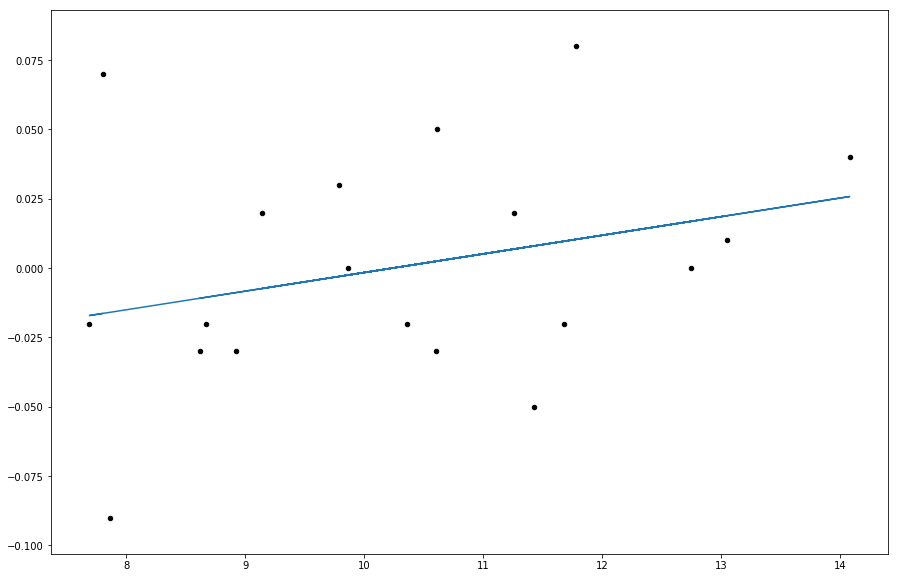

In [4]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Z'])
print("raw: ", *popt)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


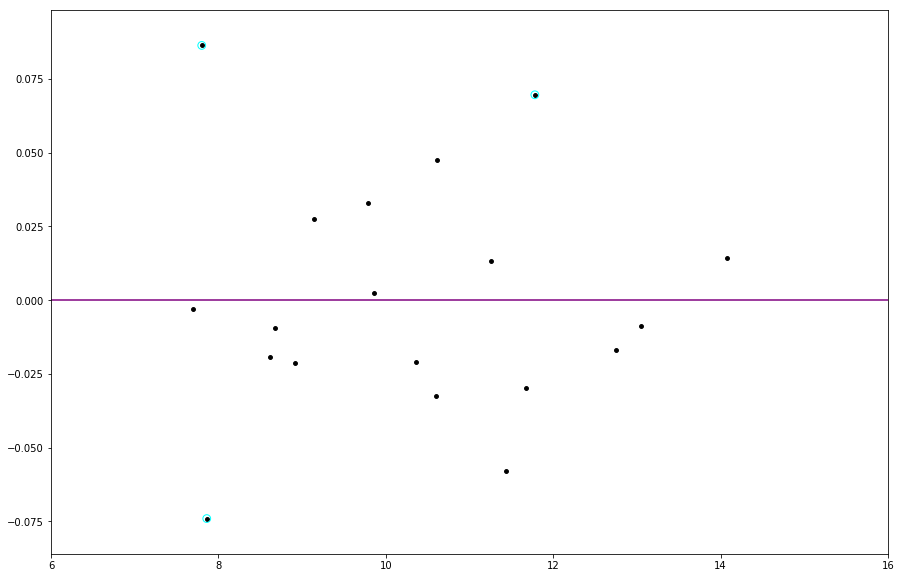

In [13]:
#Let's look into which data are way off the fit.

residual = data['Z']-linear(data['X'],*popt)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.06
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  0.006717675713445995 -0.0687541345289338
outliers accounted for:  0.006766707931901099 -0.06938331416433777


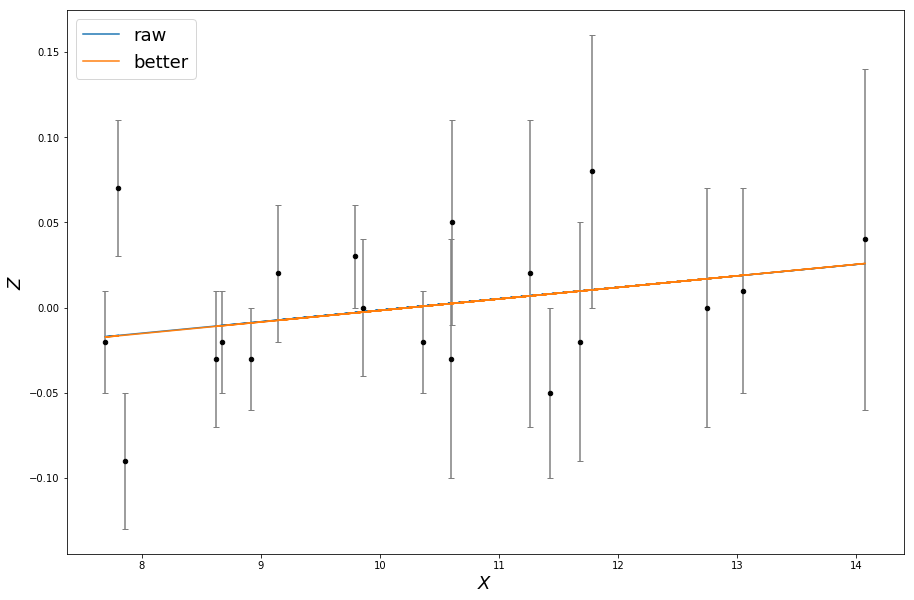

In [6]:
#above indicates no significant outliers

# our values for the raw data above:
# slope:    0.006718
# intercept: -.068754
popt, pcov = opt.curve_fit(linear, data['X'], data['Z'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Z'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
ax.errorbar(data['X'],data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

#notice that due to significant outliers, better and raw are nearly identical

0.005358711605572734 -0.058178020691403


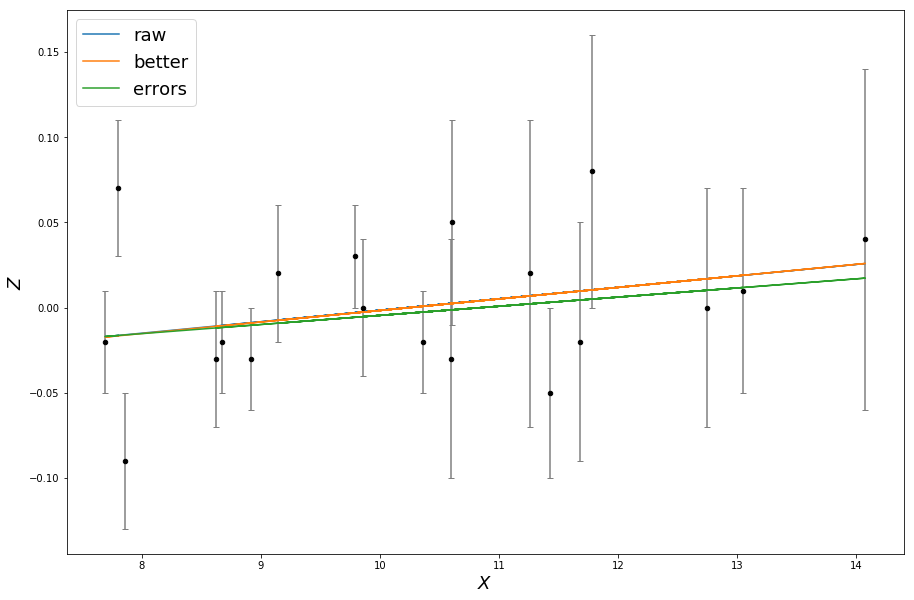

In [7]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Z'], sigma=data['Z_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0068, mean intercept: -0.0690


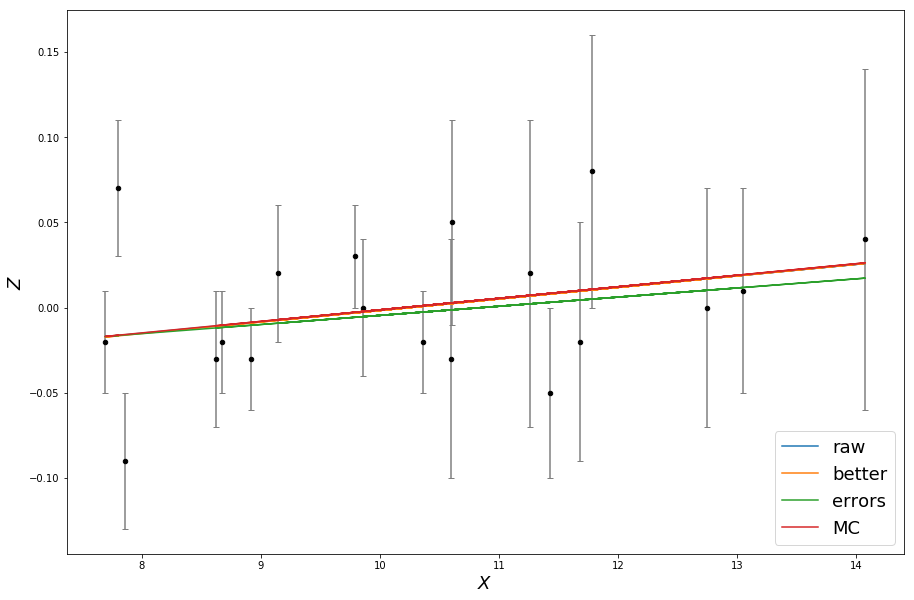

In [8]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)-- following is the simple way to write a gaussian!!
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Z'], data['Z_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [14]:
# oh right, that outlier.

mask = data['Z'] < 0.3

xdat = data['X'][mask]
ydat = data['Z'][mask]
ydat_err = data['Z_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  19
slope: +0.0065 $\pm$ 0.0089, mean intercept: -0.0677


slope: +0.0066 $\pm$ 0.0083, mean intercept: -0.0685
slope: +0.0070 $\pm$ 0.0084, mean intercept: -0.0704
slope: +0.0071 $\pm$ 0.0083, mean intercept: -0.0736
slope: +0.0063 $\pm$ 0.0080, mean intercept: -0.0650
slope: +0.0066 $\pm$ 0.0089, mean intercept: -0.0680
slope: +0.0062 $\pm$ 0.0079, mean intercept: -0.0638
slope: +0.0062 $\pm$ 0.0083, mean intercept: -0.0632
slope: +0.0068 $\pm$ 0.0083, mean intercept: -0.0699
slope: +0.0067 $\pm$ 0.0081, mean intercept: -0.0685
slope: +0.0069 $\pm$ 0.0085, mean intercept: -0.0699
slope: +0.0072 $\pm$ 0.0084, mean intercept: -0.0726
slope: +0.0070 $\pm$ 0.0086, mean intercept: -0.0714
slope: +0.0065 $\pm$ 0.0083, mean intercept: -0.0670
slope: +0.0065 $\pm$ 0.0078, mean intercept: -0.0658
slope: +0.0070 $\pm$ 0.0084, mean intercept: -0.0713
slope: +0.0073 $\pm$ 0.0082, mean intercept: -0.0743
slope: +0.0069 $\pm$ 0.0081, mean intercept: -0.0708
slope: +0.0072 $\pm$ 0.0087, 

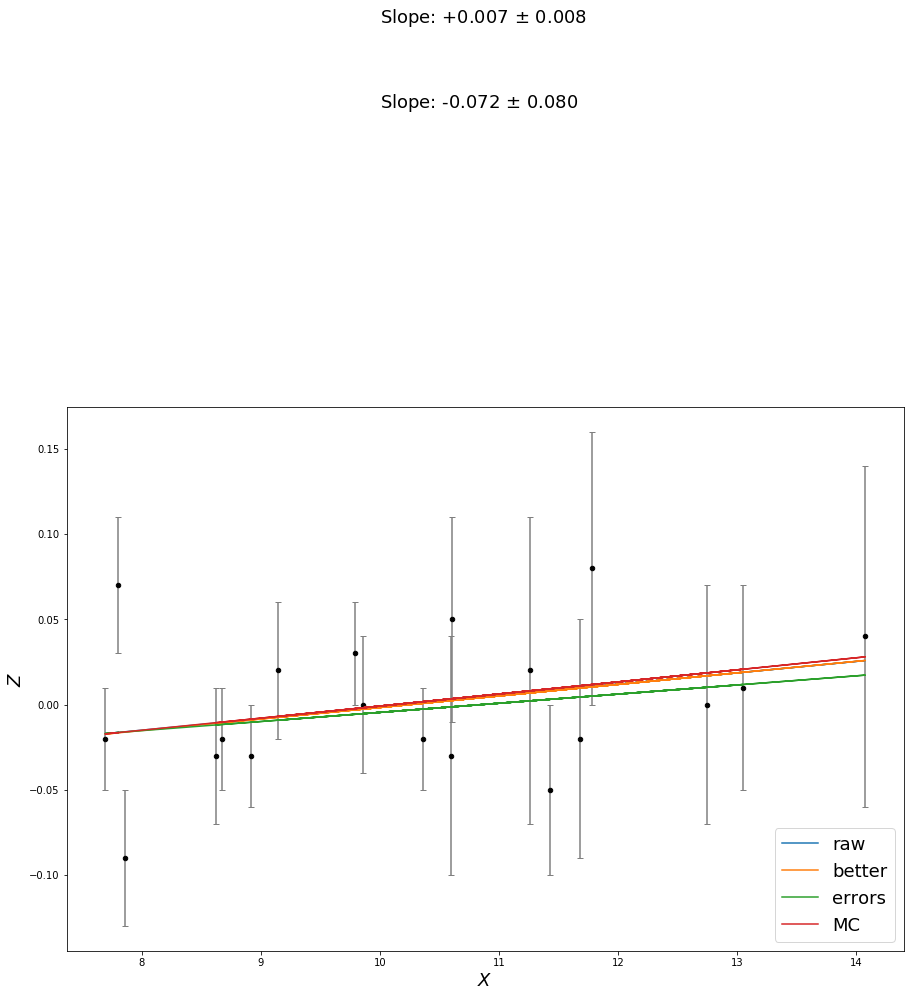

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.07246370032993199


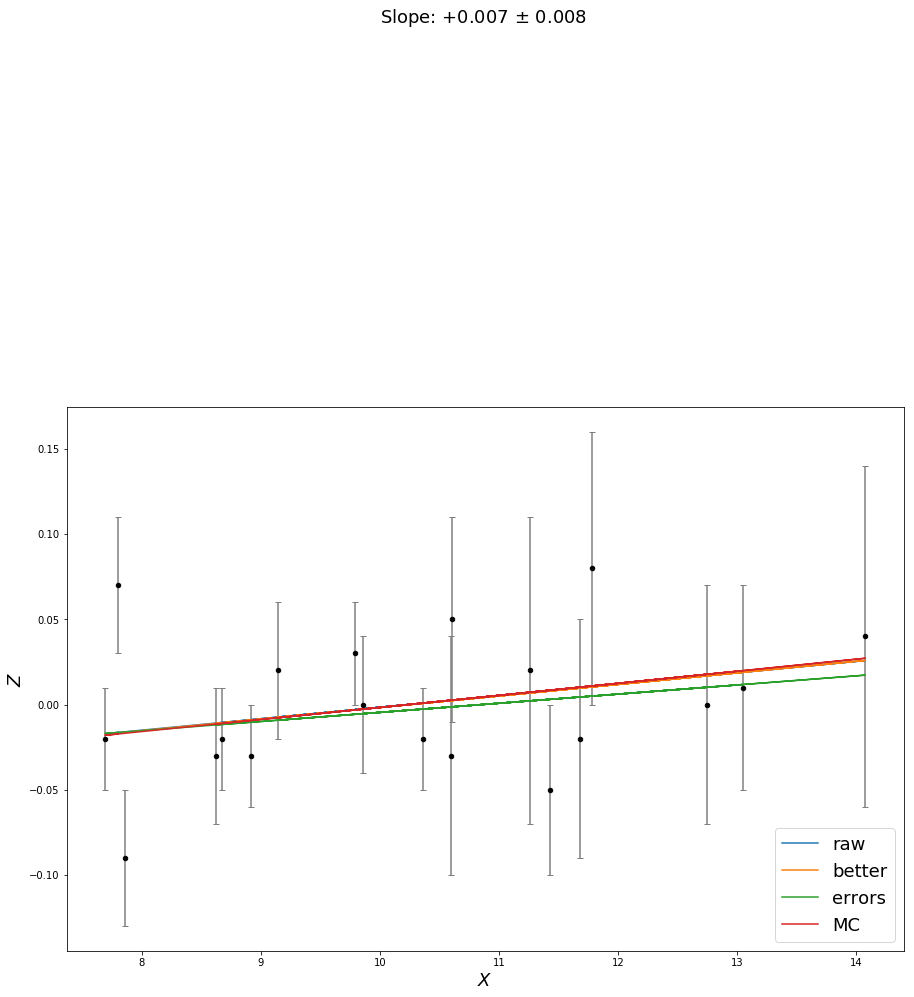

In [16]:
# here's an example of the use of lampda functions: simplifying or modifying another function
params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0061, mean intercept: -0.0629
-0.06251386184557273


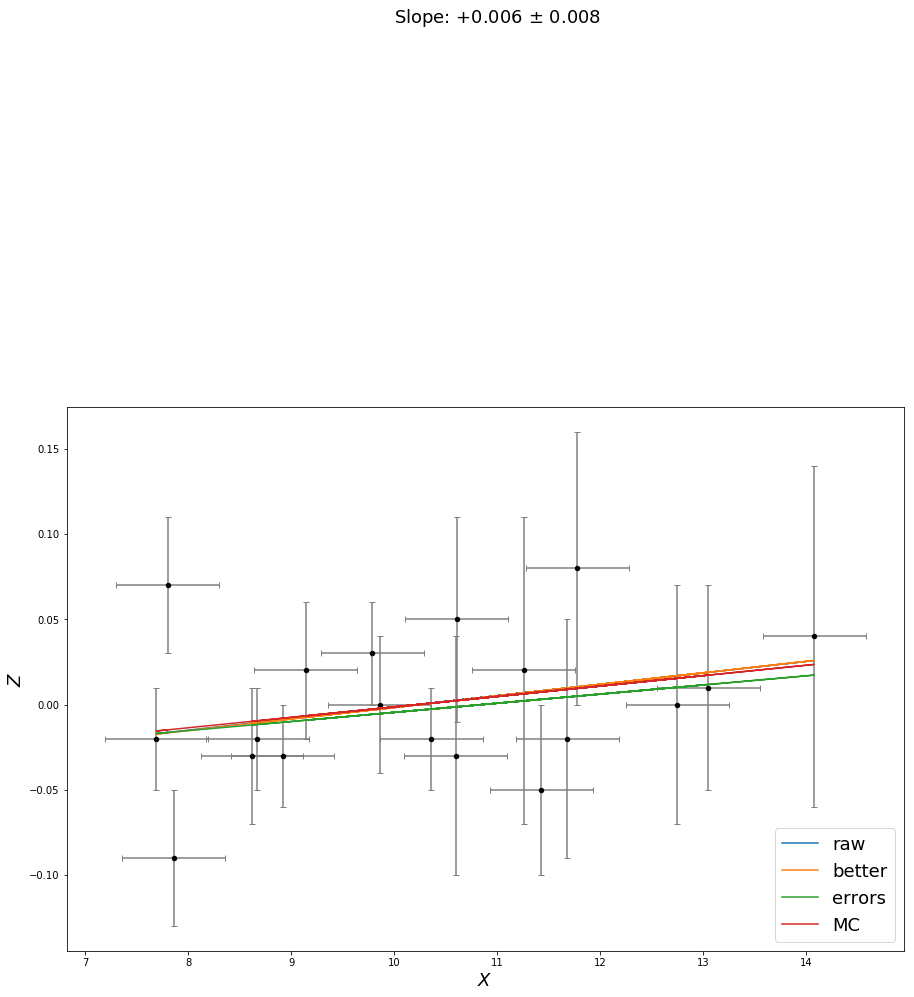

In [17]:
# exercise: we can't know the x data perfectly
# suppose the data have uniform x errors of 0.5
# use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors

#defining X-error
X_ERR = []
for i in range(19):
    X_ERR.append(0.5)
#print(X_ERR)

#defining a MC fit including X-error
def mcTotalFit(x, y, x_err, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)-- following is the simple way to write a gaussian!!
        weights = np.random.randn(len(y))
        weights2 = np.random.randn(len(x))

        y_adj = y + y_err*weights
        x_adj = x + x_err*weights2

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

#values calculated from the new defined fuction, includes X_ERR
slope, intercept = mcTotalFit(data['X'], data['Z'], X_ERR, data['Z_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
ax.errorbar(data['X'], data['Z'],xerr=X_ERR, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0061, mean intercept: -0.0641
-0.062722142474529


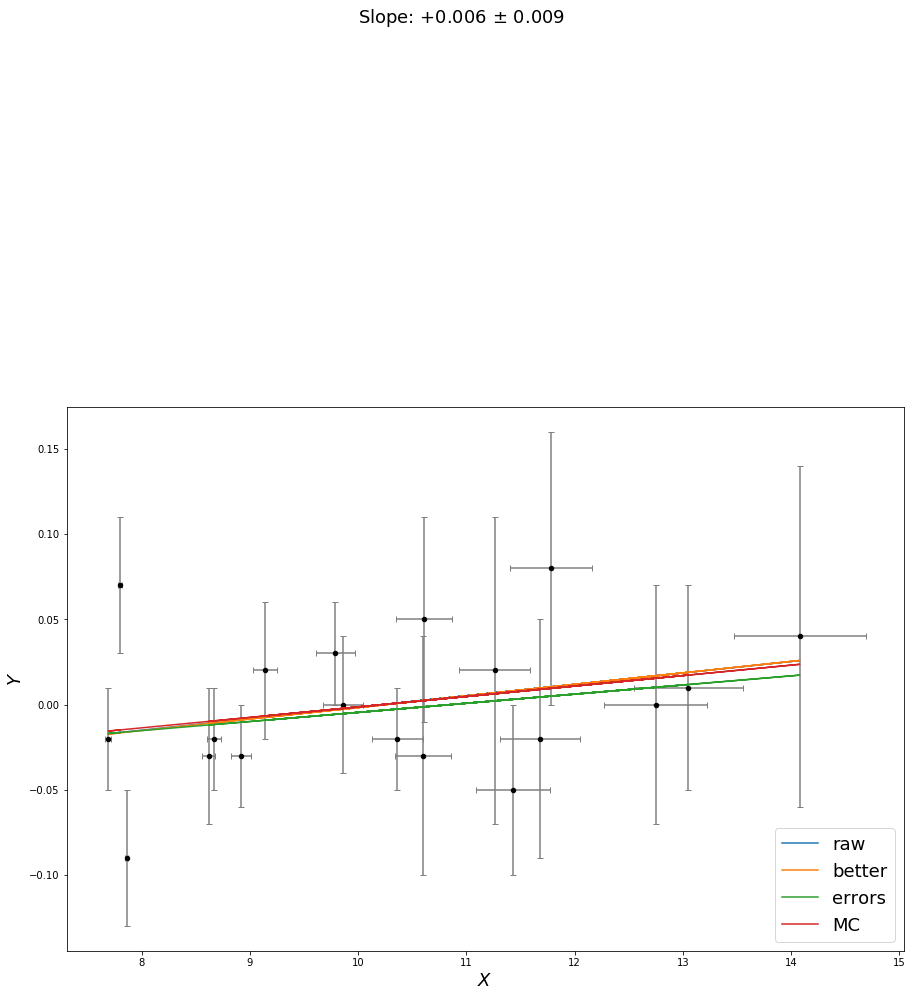

In [18]:
# repeat this exercise, but supposing the errors INCREASE as we move away from X = 8 (as they do)
# to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit 



#defining X-error- notice X_ERR had to be an np.array due to a cross reference with the X data set
X_ERR1 = np.array((np.absolute(data['X']-8.0))/10.0)
#for i in range(19):
#X_ERR1.append((np.absolute(data['X']-8.0))/10.0)
#print(X_ERR1)
#print(data['Z_ERR'])


#values calculated from the new defined fuction, includes X_ERR
slope, intercept = mcTotalFit(data['X'], data['Z'], X_ERR1,data['Z_ERR'])
                              
print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
ax.errorbar(data['X'], data['Z'],xerr=X_ERR1, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()
